<a href="https://colab.research.google.com/github/ShivakumarRavi/Syntactic_Processing/blob/main/Syntactic_Processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Entities in Healthcare Data

By: Shivakumar Ravichandran

## Workspace set up: Import and Install useful packages.

In [1]:
!pip install pycrf
!pip install sklearn-crfsuite

  Preparing metadata (setup.py) ... done
  Created wheel for pycrf: filename=pycrf-0.0.1-py3-none-any.whl size=1870 sha256=a7d5fb714d4a1138f56022776bea629cee5c3433be8506aa69ac39af791d519f
  Stored in directory: /root/.cache/pip/wheels/fd/3a/fb/e4d15c9c2b169f43811b23a863ee9717ff3eda5d2301789043
Successfully built pycrf
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 24.1 MB/s eta 0:00:00


In [3]:
import spacy
import sklearn_crfsuite
from sklearn_crfsuite import metrics

model = spacy.load("en_core_web_sm")
import numpy as np
import pandas as pd
import re
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

## **Data Preprocessing**
The dataset provided is in the form of one word per line. Let's understand the format of data below:

* Suppose there are x words in a sentence, then there will be x continuous lines with one word in each line.
* Further, the two sentences are separated by empty lines. The labels for the data follow the same format.

**We need to pre-process the data to recover the complete sentences and their labels.**



## Construct the proper sentences from individual words and print the 5 sentences.

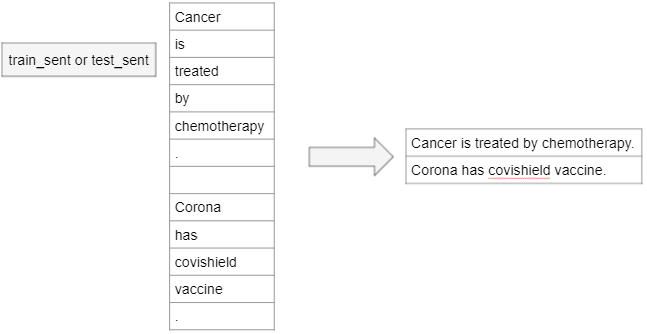

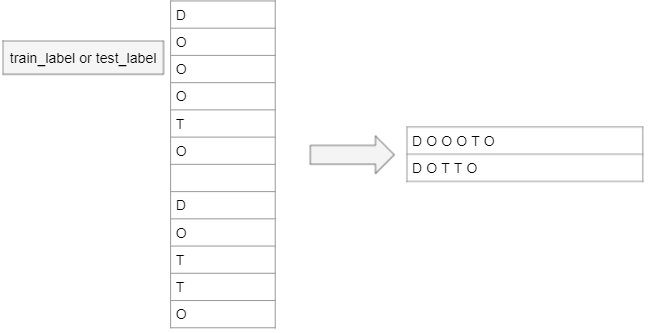

To decipher the given corpus which is given one word at a time in one line, and create sentences out of the, I have created this function below named unpack_given_file. This function takes the file name as input and unpacks line by line to form sentences. It returns the List of sentences to the calling module.

In [4]:
def unpack_given_file(file_name):
    ''' This function takes the file name as input and unpacks line by line to form sentences. It returns the List of sentences'''
    file=open(file_name,'r') # Open the file
    data=file.readlines() # Perform line by line reading
    file.close() # Close the file
    L=[];sent=[] # initialize two empty lists L is temporary to create each sentence and sent is the list of sentences returned
    for line in data:
        if line == '\n': # empty line encountered
            sent.append(" ".join(L)) # Creating a sentence
            L=[] # reset the temporary list
        else:
            L.append(line.rstrip('\n')) # Keep adding to the temporary list
    return sent

In [5]:
# Unpacking the train sentences
train_set=unpack_given_file('train_sent')
train_set[10:15] # Checking 5 sentences from 10-14

['A 2- , 3- , and 4-day mean temperature prior to the test date was compared to AFI using a Spearman-rank Correlation',
 'This relationship should be taken into account when interpreting the AFI as a measure of fetal well-being',
 'The study population included 84 women with gestational diabetes , ascertained by universal screening of all women attending the antenatal clinic of the Hadassah Medical Center , over a 2-year period',
 "The 60 women ( 71 % ) , who initiated treatment before 34 completed weeks , composed the `` early '' group",
 "The 24 women ( 29 % ) , who initiated treatment after the 34th week , composed the `` late '' group"]

In [6]:
# Unpacking train labels
train_label=unpack_given_file('train_label')
train_label[10:15] # Checking 5 labels from 10-14

['O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O',
 'O O O O O O O D D O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O']

In [7]:
# Unpacking test sentences
test_set=unpack_given_file('test_sent')
test_set[:5] # Checking first 5 sentences from test sentences

['Furthermore , when all deliveries were analyzed , regardless of risk status but limited to gestational age > or = 36 weeks , the rates did not change ( 12.6 % , 280 of 2214 ; primary 9.2 % , 183 of 1994 )',
 'As the ambient temperature increases , there is an increase in insensible fluid loss and the potential for dehydration',
 'The daily high temperature ranged from 71 to 104 degrees F and AFI values ranged from 1.7 to 24.7 cm during the study period',
 'There was a significant correlation between the 2- , 3- , and 4-day mean temperature and AFI , with the 4-day mean being the most significant ( r = 0.31 , p & # 60 ; 0.001 )',
 'Fluctuations in ambient temperature are inversely correlated to changes in AFI']

In [8]:
# Unpacking test labels
test_label=unpack_given_file('test_label')
test_label[:5] # Checking first 5 labels from test labels

['O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O O',
 'O O O O O O O O O O O']

In [9]:
# Combining trains and test sentences for Exploratory data analysis
all_sent = train_set+test_set
len(all_sent)

3655

**Observe 3655 total sentences in the corpus**

In [10]:
# Combining trains and test labels for Exploratory data analysis
all_labels=train_label+test_label
len(all_labels)

3655

Similarly, observe 3655 total labels in the entire given corpus

In [11]:
# Creating a dataframe out of the given sentences and labels
df=pd.DataFrame(list(zip(all_sent,all_labels)), columns=['sentences','labels'])
df.head()

,sentences,labels
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O


In [12]:
# Creating new columns which is the total number of O tags, D tags and T tags in a sentence/document

df['O_label']=df.labels.apply(lambda x: len(re.findall('O',x))) # Get total number of O labels in the given sentence
df['D_label']=df.labels.apply(lambda x: len(re.findall('D',x))) # Get total number of D labels in the given sentence
df['T_label']=df.labels.apply(lambda x: len(re.findall('T',x))) # Get total number of T labels in the given sentence
df.tail(15) # Checking the last 15 rows of the dataframe

,sentences,labels,O_label,D_label,T_label
3640,Efficacy of open-bite treatment with the Thera...,O O D O O O T,5,1,1
3641,Hepatic arterial infusion of chemotherapy afte...,O O O O T O T O D D O D D,7,4,2
3642,Evidence for double resistance to permethrin a...,O O O O O T T T O D D,6,2,3
3643,Urgent colonoscopy for the diagnosis and treat...,O T O O O O O O D D D,7,3,1
3644,"Effects of tolcapone , a catechol-O-methyltran...",O O T T T T T O O O O O O O T O O O D D D O,13,3,6
3645,"Dry powdered formoterol , twice a day versus a...",T T T O O O O O T T O O O O O O O O O D D,14,2,5
3646,Celecoxib for arthritis,T O D,1,1,1
3647,Poliomyelitis prevention : revised recommendat...,D O O O O O O O O O O O D T,11,2,1
3648,Brimonidine tartrate 0.2 % twice daily vs timo...,T T O O O O O T O O O O O O O O D O,14,1,3
3649,Epoetin : a pharmacoeconomic review of its use...,T O O O O O O O O D D D O O O O O O O,15,3,1


## Exploratory data analysis EDA

In [13]:
df.describe()

,O_label,D_label,T_label
count,3655.000000,3655.000000,3655.000000
mean,15.269494,1.337620,1.045417
std,12.396386,2.109442,2.377397
min,0.000000,0.000000,0.000000
25%,6.000000,0.000000,0.000000
50%,12.000000,0.000000,0.000000
75%,21.000000,2.000000,1.000000
max,125.000000,34.000000,30.000000


We can clearly observe here that the number of D labels at 50% quantile is 0 which indicates that less than half of the given corpus have the D labels and even lesser corpus have T labels. Note that even T labels are 0 at 50% quantile.

In [14]:
df.shape

(3655, 5)

In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3655 entries, 0 to 3654
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentences  3655 non-null   object
 1   labels     3655 non-null   object
 2   O_label    3655 non-null   int64 
 3   D_label    3655 non-null   int64 
 4   T_label    3655 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 142.9+ KB


In [16]:
df[df.T_label>25]

,sentences,labels,O_label,D_label,T_label
2037,only the combination of a cell wall-active ant...,O O T T T T T T T T T T T T T T T T T T T T T ...,21,9,30
2090,objective : to examine the effectiveness of ni...,O O O O O O O T T T T T T T T T T T T T T T T ...,9,2,28
2315,A three-step treatment algorithm for refractor...,O O O O O D D O O T T T T T T T T T T T T T T ...,22,2,28


In [17]:
df[(df.T_label==0)&(df.D_label==0)]

,sentences,labels,O_label,D_label,T_label
0,All live births > or = 23 weeks at the Univers...,O O O O O O O O O O O O O O O O O O O O O O O ...,45,0,0
1,The total cesarean rate was 14.4 % ( 344 of 23...,O O O O O O O O O O O O O O O O O O O O O O O O O,25,0,0
2,Abnormal presentation was the most common indi...,O O O O O O O O O O O O O O O,15,0,0
3,The `` corrected '' cesarean rate ( maternal-f...,O O O O O O O O O O O O O O O O O O O O O O O ...,38,0,0
4,Arrest of dilation was the most common indicat...,O O O O O O O O O O O O O O O O O O O O O O,22,0,0
...,...,...,...,...,...
3410,Relatives in the resuscitation room : their po...,O O O O O O O O O O,10,0,0
3412,Subcutaneous autologous ovarian transplantatio...,O O O O O O O O O O,10,0,0
3417,Adolescent pregnancy and sexual abuse,O O O O O,5,0,0
3418,Still hard to know how large the benefits will...,O O O O O O O O O O O,11,0,0


Total of 1843 rows in the total sentences has only O (Others) tags.

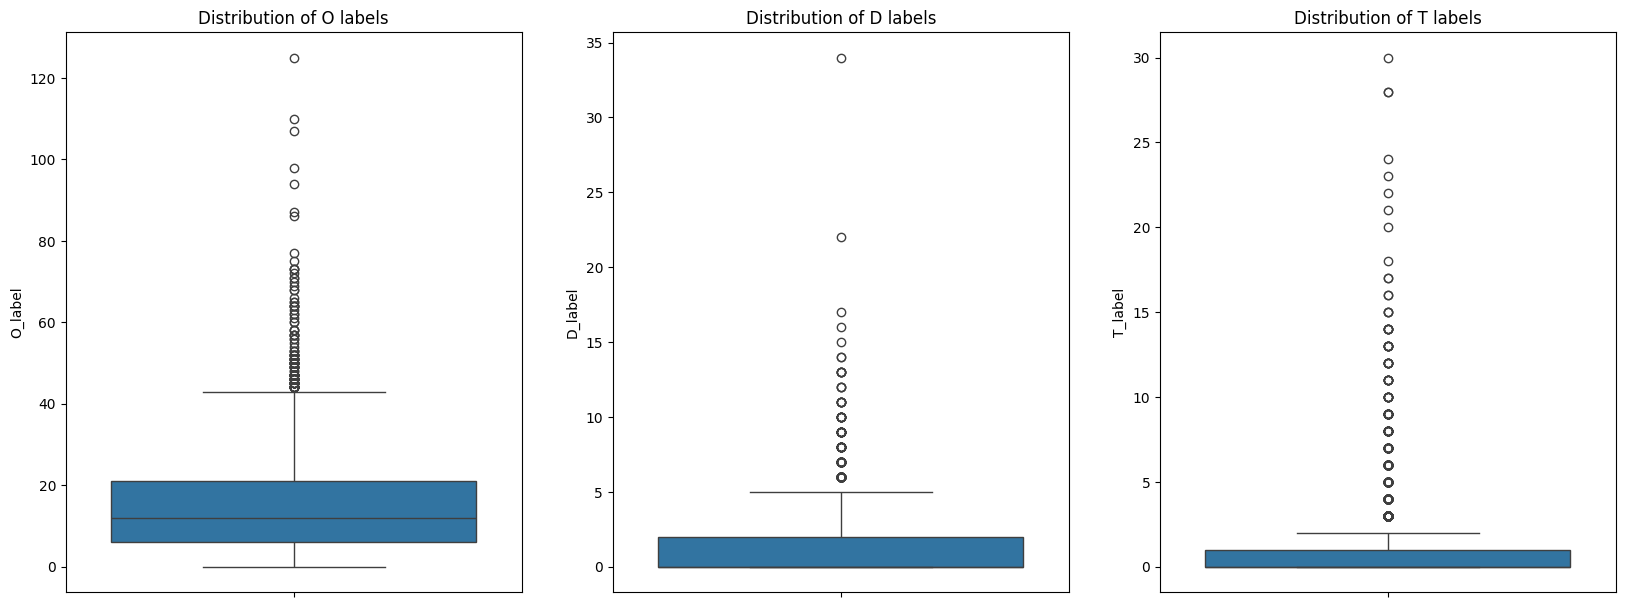

In [18]:
plt.figure(figsize=(20,16))
plt.subplot(2,3,1)
plt.title('Distribution of O labels')
sns.boxplot(df.O_label)
plt.subplot(2,3,2)
plt.title('Distribution of D labels')
sns.boxplot(df.D_label)
plt.subplot(2,3,3)
plt.title('Distribution of T labels')
sns.boxplot(df.T_label)
plt.show()

During the EDA we can observe that per sentence, the distribution of the O label is above 120 in some sentences while its overall range of its values lie around 0 to 40.
We also observe that there are comparatively few sentences that has D labels and even lesser of T labels.
This observation can also be verifed in the describe function of the labels.

### Count the number of sentences in the processed train and test dataset

In [19]:
print('Number of sentences in the train set: ',len(train_set))
print('Number of sentences in the test set: ',len(test_set))

Number of sentences in the train set:  2599
Number of sentences in the test set:  1056


## Concept Identification

We will first explore what are the various concepts present in the dataset. For this, we will use PoS Tagging.

Extract those tokens which have NOUN or PROPN as their PoS tag and find their frequency

In [20]:
noun_or_propn=[] # initialize empty list
for review in all_sent: #looping through all sentences i.e. train and test sentences
    doc=model(review) # applying the NLP model on the sentence
    for token in doc: # Looping through the tokens created by the model
        if token.pos_=='NOUN' or token.pos_=='PROPN': # Checking if the pos_ tag is 'NOUN' or 'PROPN'
            noun_or_propn.append(token.lemma_.lower()) # add to the list

In [21]:
pd.Series(noun_or_propn).value_counts().head(25)

patient         568
treatment       316
%               247
study           236
cancer          226
cell            203
therapy         182
effect          181
disease         170
group           145
case            132
result          121
lung            120
gene            111
year            105
rate            103
use              91
chemotherapy     91
trial            90
woman            89
conclusion       89
analysis         86
protein          82
response         81
risk             78
Name: count, dtype: int64

Here we can observe the top 25 noun and proper nouns. This indicates that the data is of a study about cancer, effects, therapy, case study, lung. We can observe 91 counts of chemotherapy.

In [22]:
dict_of_words=pd.Series(noun_or_propn).value_counts().to_dict()
dict_of_words

{'patient': 568,
 'treatment': 316,
 '%': 247,
 'study': 236,
 'cancer': 226,
 'cell': 203,
 'therapy': 182,
 'effect': 181,
 'disease': 170,
 'group': 145,
 'case': 132,
 'result': 121,
 'lung': 120,
 'gene': 111,
 'year': 105,
 'rate': 103,
 'use': 91,
 'chemotherapy': 91,
 'trial': 90,
 'woman': 89,
 'conclusion': 89,
 'analysis': 86,
 'protein': 82,
 'response': 81,
 'risk': 78,
 'child': 77,
 'dose': 77,
 'mutation': 74,
 'to_see': 74,
 'drug': 74,
 'tumor': 74,
 'surgery': 73,
 'p': 72,
 'method': 70,
 'control': 69,
 'infection': 68,
 'survival': 67,
 'factor': 67,
 'day': 63,
 'evidence': 62,
 'combination': 62,
 'age': 61,
 'health': 61,
 'term': 61,
 'syndrome': 60,
 'activity': 60,
 'management': 56,
 'care': 56,
 'stage': 55,
 'datum': 54,
 'acid': 54,
 'c': 54,
 'month': 54,
 'bone': 53,
 'time': 53,
 'carcinoma': 53,
 'diagnosis': 52,
 'role': 50,
 'practice': 49,
 'week': 48,
 'b': 47,
 'outcome': 46,
 '#': 46,
 'pregnancy': 46,
 'blood': 46,
 'family': 45,
 'heart': 45,

In [23]:
len(noun_or_propn)

24373

As we can see we have 24,327 words found that has parts of speech (PoS) tag of nouns or proper nouns from our model

## Defining features for CRF

Computing Features using the following features for our input sequences.

We have defined the following features for CRF model building:

* f1=postag of the word
* f2=word in lower case
* f3=last 3 characters of the word
* f4=last 2 characters of the word
* f5=1; if the word is in uppercase, otherwise 0
* f6=1; if word is a number; otherwise 0
* f7=1; if the word starts with a capital letter, otherwise 0
* If the given word is not the beginning of the sentence, we include the features of the previous word too
* If the word is at the beginning of sentence we mark it as 'BEG'
* If the word is at the end of the sentence we mark it as 'END'

In [24]:
# Let's define the features to get the feature value for one word.
def getFeaturesForOneWord(sentence, pos):
  word=sentence[pos]
  for token in model(word):
    word_pos_tag=token.pos_
  features=[
    'word.postag='+word_pos_tag, # f1 is the PoS tag of the word
    'word.lower='+word.lower(), # f2 is input word is in lower case
    'word[-3:]='+word[-3:], # Last three characters
    'word[-2:]='+word[-2:], # Last two characters
    'word.isupper=%s' % word.isupper(), # is the word in all upper case
    'word.isdigit=%s' % word.isdigit(), # is the word a number
    'words.startsWithCapital=%s' %word[0].isupper() # is the word starting with capital letter
  ]
  if pos>0:
    prev_word=sentence[pos-1]
    for token in model(prev_word):
      prev_word_pos_tag=token.pos_
    features.extend([
      'prev_word.postag='+prev_word_pos_tag, # previous word PoS tag
      'prev_word.lower=' + prev_word.lower(), # previous word in lower case
      'prev_word.isupper=%s' % prev_word.isupper(), # is previous word in upper case
      'prev_word.isdigit=%s' % prev_word.isdigit(), # is previous word a number
      'prev_words.startsWithCapital=%s' % prev_word[0].isupper() # is previous word starting with capital letter
    ])
  else:
    features.append('BEG') # Beginning of sentence
  if (pos == len(sentence)-1):
    features.append('END') # End of sentence
  return features

## Getting the features

Write a code/function to get the features for a sentence

In [25]:
# Write a code to get features for a sentence.
def getFeaturesForOneSentence(sentence):
  sentence_list = sentence.split()
  return [getFeaturesForOneWord(sentence_list, pos) for pos in range(len(sentence_list))]

Write a code/function to get the labels of a sentence

In [26]:
# Write a code to get the labels for a sentence.
def getLabelsInListForOneSentence(labels):
  return labels.split()

In [27]:
# Checking the workings of our feature on an example sentence from the trains set
example_sentence = train_set[5] # Choosing 6th sentence
print(example_sentence) # Printing the entire sentence for reference

example_features = getFeaturesForOneSentence(example_sentence)
example_features[5] # Choosing the 6th word

Cesarean rates at tertiary care hospitals should be compared with rates at community hospitals only after correcting for dissimilar patient groups or gestational age


['word.postag=NOUN',
 'word.lower=hospitals',
 'word[-3:]=als',
 'word[-2:]=ls',
 'word.isupper=False',
 'word.isdigit=False',
 'words.startsWithCapital=False',
 'prev_word.postag=VERB',
 'prev_word.lower=care',
 'prev_word.isupper=False',
 'prev_word.isdigit=False',
 'prev_words.startsWithCapital=False']

As we can see the features are correctly defined for the word hospitals

## Define input and target variables

Correctly computing X and Y sequence matrices for training and test data. Check that both sentences and labels are processed

Define the features' values for each sentence as input variable for CRF model in test and the train dataset

In [28]:
X_train = [getFeaturesForOneSentence(sentence) for sentence in train_set]
Y_train = [getLabelsInListForOneSentence(labels) for labels in train_label]

Define the labels as the target variable for test and the train dataset

In [29]:
X_test = [getFeaturesForOneSentence(sentence) for sentence in test_set]
Y_test = [getLabelsInListForOneSentence(labels) for labels in test_label]

## Build the CRF Model

In [33]:
# Build the CRF model.
crf=sklearn_crfsuite.CRF(max_iterations=100)
try:
    crf.fit(X_train, Y_train)
except AttributeError:
    pass

## Evaluation

Predict the labels of each of the tokens in each sentence of the test dataset that has been pre processed earlier.

In [34]:
Y_pred=crf.predict(X_test)

Calculate the f1 score using the actual labels and the predicted labels of the test dataset.

In [35]:
metrics.flat_f1_score(Y_test, Y_pred, average='weighted')

0.9086027308076594

We have got the f1 score of 0.90860

In [39]:
# Testing a sample prediction against actual values
# Print the orginal labels and predicted labels for the sentence  in test data, which is at index value 500
id = 500
print("Sentence:",test_set[id])
print("Orig Labels:", Y_test[id])
print("Pred Labels:", Y_pred[id])

Sentence: > From the Centers for Disease Control and Prevention
Orig Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']
Pred Labels: ['O', 'O', 'O', 'O', 'O', 'O', 'O', 'O', 'O']


As we can see, the record at 1001 sentence is a correct prediction.

## Identifying Diseases and Treatments using Custom NER

We now use the CRF model's prediction to prepare a record of diseases identified in the corpus and treatments used for the diseases.

Create the logic to get all the predicted treatments (T) labels corresponding to each disease (D) label in the test dataset.

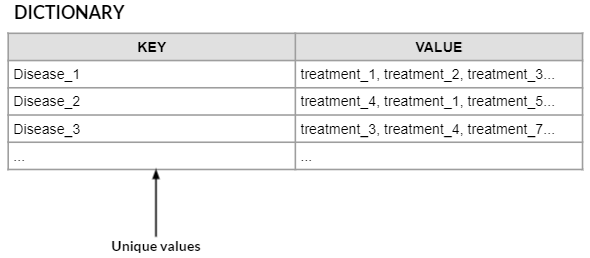

In [40]:
# Creating dictionary out of the predicted labels from our model
dict={}
for count, labels in enumerate(Y_pred): # we are taking the Y-pred labels and count will have the record ID
    temp="".join(labels) # removing the spaces between the lablels
    #print(count, temp)
    totalD=len(re.findall('D',temp)) # find number of 'D' in the sentence
    totalT=len(re.findall('T',temp)) # find number of 'T' in the sentence
    if totalD>0 and totalT>0: # this means that the sentence has disease and treatment
        indexD=[];indexT=[];start_from=0 # Initializing variables used
        for i in range(totalD):
            foundat=temp.find('D',start_from) # search for 'D' from start_from in the labels
            indexD.append(foundat) # put the foundat index in a list called indexD
            start_from=foundat+1 # re-initialize start_from from the next word
        start_from=0 # initialize the same variable for 'T' labels now
        for i in range(totalT):
            foundat=temp.find('T',start_from) # search for 'T' from start_from in the labels
            indexT.append(foundat) # put the foundat index in a list called indexT
            start_from=foundat+1 # re-initialize start_from from the next word
        disease='' # Initialize the string disease with empty string
        for i in indexD: # Looping through the indexes where 'D' is located
            disease=disease+test_set[count].split()[i] # we are taking i-th word of the count which is index of sentence
            if i+1 not in indexD: # Check condition if the next word is also in the list
                disease=disease+', ' # this will be executed for a new disease
            else:
                disease=disease+' ' # this will be executed for continuation of disease name
        treatment='' # Initialize the string treatment with empty string
        for i in indexT: # Looping through the indexes where 'D' is located
            treatment=treatment+test_set[count].split()[i] # we are taking i-th word of the count which is index of sentence
            if i+1 not in indexT: # Check condition if the next word is also in the list
                treatment=treatment+', ' # this will be executed for a new treatment
            else:
                treatment=treatment+' ' # this will be executed for continuation of treatment
        # finally entering the disease and treatment in the dictionary after removing the last comma and space character
        dict[disease.rstrip(', ')]=treatment.rstrip(', ')

dict

{'nonimmune hydrops fetalis': 'Trisomy',
 'hereditary retinoblastoma': 'radiotherapy',
 'unstable angina or non-Q-wave myocardial infarction': 'roxithromycin',
 'coronary-artery disease': 'Antichlamydial antibiotics',
 'cellulitis': 'G-CSF therapy, intravenous antibiotic treatment',
 'foot infection': 'G-CSF treatment',
 "early Parkinson 's disease": 'Ropinirole monotherapy',
 'sore throat': 'Antibiotics',
 "abdominal tuberculosis, Crohn 's disease": 'steroids',
 'treating stress urinary incontinence': 'surgical procedures',
 'female stress urinary incontinence': 'surgical treatment',
 'stress urinary incontinence': 'therapy',
 'preeclampsia ( proteinuric hypertension )': 'intrauterine insemination with donor sperm versus intrauterine insemination',
 'intra-abdominal injury': 'senior surgery',
 'severe acquired hyperammonemia, cancer': 'organ transplantation and chemotherapy',
 'major pulmonary embolism': 'Thrombolytic treatment, right-side hemodynamics',
 'malignant pleural mesothelio

In [41]:
# Creating dataframe out of the dictionary of disease and treatment
df1=pd.DataFrame(dict.items(),columns=['disease','treatment'])
df1.head()

,disease,treatment
0,nonimmune hydrops fetalis,Trisomy
1,hereditary retinoblastoma,radiotherapy
2,unstable angina or non-Q-wave myocardial infar...,roxithromycin
3,coronary-artery disease,Antichlamydial antibiotics
4,cellulitis,"G-CSF therapy, intravenous antibiotic treatment"


## Predict the treatment for the disease name: 'hereditary retinoblastoma'

In [42]:
dict['hereditary retinoblastoma']

'radiotherapy'

Here we can conclude that the treatment for ***heriditary retinoblastoma*** is ***radiotherapy***